<a href="https://colab.research.google.com/github/emilianodesu/RLA2/blob/main/breakout/breakout_ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![View on GitHub](https://img.shields.io/badge/GitHub-Repo-blue?logo=github)](https://github.com/emilianodesu/RLA2)

## Cloning repository to execute in Google Colab

In [1]:
import os
def detect_colab() -> bool:
    """
    Detect whether the runtime is Google Colab.

    Returns:
        bool: True if running in Google Colab; False otherwise.
    """
    try:
        import google.colab  # type: ignore
        return True
    except ImportError:
        return False

IN_COLAB = detect_colab()
BASE_PATH = '/content/' if IN_COLAB else './'

print(f"IN_COLAB: {IN_COLAB}")
print(f"BASE_PATH: {BASE_PATH}")

if IN_COLAB:
    # Clone Github repo
    if not os.path.exists(f"{BASE_PATH}/RLA2"):
        !git clone https://github.com/emilianodesu/RLA2.git
    os.chdir(f"{BASE_PATH}/RLA2")
    print(f"Current directory: {os.getcwd()}")

IN_COLAB: True
BASE_PATH: /content/
Cloning into 'RLA2'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 135 (delta 37), reused 83 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (135/135), 5.62 MiB | 13.32 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Filtering content: 100% (22/22), 506.03 MiB | 52.60 MiB/s, done.
Current directory: /content/RLA2


# PPO on Atari games using Custom CNN

This notebook will explore the implementation of PPO from Stable Baseline3 using a Custom CNN feature extractor on Atari Environment.

### What you will learn?
* Using PPO from Stable Baseline3 Using Custom CNN
* Training on Breakout Environment

## Setup
Install necessary dependencies.

In [2]:
# Installing the necessary packages for Atari environments
!pip install gymnasium
!pip install gymnasium[atari]
!pip install ale-py
# Installing Stable Baselines3 with extra dependencies
!pip install "stable-baselines3[extra]"
!pip install moviepy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 6.8 MB/s eta 0:00:00


In [4]:
# Installing necessary packages for visualization and virtual display
!sudo apt-get update
!sudo apt-get install -y cmake
# Updating the package list and installing ffmpeg and freeglut3-dev for visualization, xvfb for virtual display
!sudo apt-get install -y ffmpeg freeglut3-dev xvfb

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [5]:
if not IN_COLAB: # only for AWS sagemaker
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # suppress TF INFO/WARN/ERROR

Import libraries

In [6]:
# Import necessary libraries and modules
import gymnasium as gym
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path
import base64
from IPython import display as ipythondisplay

# Import utility functions for creating Atari environments and stacking frames
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack

print(f"{gym.__version__=}")
print(f"{stable_baselines3.__version__=}")

gym.__version__='1.2.1'
stable_baselines3.__version__='2.7.0'


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Configure Environment

In [7]:
# Set up a fake display for rendering videos in the cloud environment
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

## Callbacks and directory setup

In [8]:
# Callback for saving the model at regular intervals
class SaveOnIntervalCallback(BaseCallback):
    def __init__(self, save_interval: int, save_path: str, verbose=1):
        super().__init__(verbose)
        self.save_interval = save_interval
        self.save_path = save_path

    def _on_step(self) -> bool:
        if self.num_timesteps % self.save_interval == 0:
            save_file = os.path.join(self.save_path, f'model_{self.num_timesteps}')
            self.model.save(save_file)
            if self.verbose > 0:
                print(f'Saving model to {save_file}.zip')
        return True

In [9]:
# Creating directories for storing logs and models
if IN_COLAB:
    log_dir = "/content/RLA2/breakout/ppo/logs/"
    models_dir = "/content/RLA2/breakout/ppo/models/"
    videos_dir = "/content/RLA2/breakout/ppo/videos/"
else:
    log_dir = "ppo/logs/"
    models_dir = "ppo/models/"
    videos_dir = "ppo/videos"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

## Define Custom Feature Extractor and Create DQN Model

In [10]:
# Custom CNN Feature Extractor
class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 512):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # The observation space shape for Atari is (4, 84, 84) after frame stacking and processing
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute the size of the output of the CNN
        with torch.no_grad():
            n_flatten = self.cnn(
                torch.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

#### Initial Atari Environment for 'Breakout'

In [11]:
import ale_py
env_id = "BreakoutNoFrameskip-v4"

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
env = make_atari_env(env_id, n_envs=4, seed=0, monitor_dir=log_dir)
env = VecFrameStack(env, n_stack=4)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


#### Initial the DQN model using custon CNN feature extractor

In [ ]:
# PPO
model = PPO(
    env=env,
    policy='CnnPolicy',  # This is a placeholder, as we will override the feature extractor
    verbose=1,
    learning_rate=2.5e-4,  # Standard learning rate for PPO on Atari
    n_steps=128,          # Number of steps to run for each environment per update
    batch_size=256,       # Number of samples in a mini-batch for update
    n_epochs=4,           # Number of epochs to run when updating the policy
    gamma=0.99,           # Discount factor
    gae_lambda=0.95,      # Factor for the Generalized Advantage Estimation (GAE)
    clip_range=0.1,       # Clipping parameter for the surrogate objective
    ent_coef=0.01,        # Entropy coefficient for encouraging exploration
    # Activate your CustomCNN
    policy_kwargs={'features_extractor_class': CustomCNN}
)

Using cuda device
Wrapping the env in a VecTransposeImage.


## Train the Model

In [ ]:
# Set up the callback for saving models
save_interval = 100000
save_callback = SaveOnIntervalCallback(save_interval, models_dir)

# Set the total number of training steps
total_timesteps = 10000000

# Train the DQN agent
model.learn(total_timesteps=total_timesteps, callback=save_callback)

# Save the final trained model
final_model_path = os.path.join(models_dir, f'model_{total_timesteps}')
model.save(final_model_path)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 522      |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 210      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 512      |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 676           |
|    ep_rew_mean          | 1             |
| time/                   |               |
|    fps                  | 245           |
|    iterations           | 2             |
|    time_elapsed         | 4             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00019234512 |
|    clip_fraction        | 0             |
|    clip_range           | 0.1           |
|    entropy_loss         | -1.39         |
|    explained_variance   | -0.109        |


## Performance evaluation

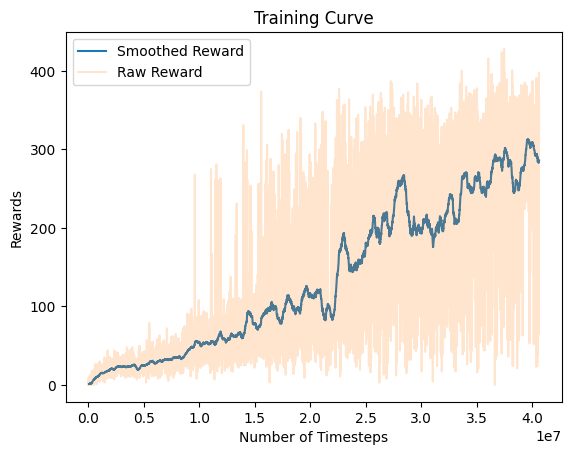

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [12]:
def plot_results(log_folder: str):
    """
    Plots the training curve from the Monitor log file.
    :param log_folder: the save directory of the Monitor logs
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')

    # Smooth the curve
    y_smooth = np.convolve(y, np.ones(100)/100, mode='valid')
    x_smooth = x[len(x) - len(y_smooth):]

    fig = plt.figure("Training Curve")
    plt.plot(x_smooth, y_smooth, label="Smoothed Reward")
    plt.plot(x, y, alpha=0.2, label="Raw Reward")
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title("Training Curve")
    plt.legend()
    plt.show()

# Call the function after training to see the learning curve
plot_results(log_dir)

## Video Recording and Display Functions

In [13]:
# Functions to record and show videos of the agent playing

def show_videos(video_path="", prefix=""):
    html = []
    for mp4 in Path(video_path).glob(f"{prefix}*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            f'''<video alt="{mp4.name}" autoplay loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{video_b64.decode('ascii')}" type="video/mp4" />
             </video>'''
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


def record_video(env_id, model, video_length=500, prefix="", video_folder="ppo/videos"):
    os.makedirs(video_folder, exist_ok=True)
    eval_env = make_atari_env(env_id, n_envs=1, seed=0, vec_env_cls=DummyVecEnv)
    eval_env = VecFrameStack(eval_env, n_stack=4)
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )
    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs, deterministic=True) # Use deterministic for evaluation
        obs, _, _, _ = eval_env.step(action)
    eval_env.close()

## Record and Display Videos at Different Training Stages

In [14]:
# Functions for analyzing the trained models

# Function to get the identifiers of saved models
def get_model_identifiers(models_dir):
    files = os.listdir(models_dir)  # Listing files in the models directory
    model_files = [f for f in files if f.startswith('model_')]  # Filtering out model files
    identifiers = [f.split('_')[1] for f in model_files]  # Extracting identifiers from file names
    return identifiers

# Function to find key identifiers (earliest, middle, final)
def find_key_identifiers(identifiers):
    identifiers.sort()  # Sorting identifiers
    earliest = identifiers[0]  # Earliest identifier
    final = identifiers[-1]  # Final identifier
    middle = identifiers[len(identifiers) // 2]  # Middle identifier
    return earliest, middle, final

# Function to view videos of the models at different training stages
def view(models_dir, video_folder="ppo/videos"):
    identifiers = get_model_identifiers(models_dir)  # Getting model identifiers
    print(identifiers)
    earliest, middle, final = find_key_identifiers(identifiers)  # Finding key identifiers

    # Recording and displaying videos at the beginning, middle, and end of training
    for stage, identifier in zip(["beginning", "middle", "end"], [earliest, middle, final]):
        model_path = os.path.join(models_dir, f'model_{identifier}')  # Forming the model path
        model = PPO.load(model_path)  # Loading the model
        record_video("BreakoutNoFrameskip-v4", model, video_length=5000, prefix=f'ppo-breakout-{stage}', video_folder=video_folder)  # Recording video
        show_videos(videos_dir, prefix=f'ppo-breakout-{stage}')  # Showing videos

In [15]:
# Changes the model directory below
view(models_dir=models_dir, video_folder=videos_dir)  # Calling the view function

['4000000.zip', '1000000.zip', '9000000.zip', '5000000.zip', '3000000.zip', '6000000.zip', '8000000.zip', '7000000.zip', '2000000.zip', '10000000.zip', '100000.zip']
Saving video to /content/RLA2/breakout/ppo/videos/ppo-breakout-beginning-step-0-to-step-5000.mp4


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Moviepy - Building video /content/RLA2/breakout/ppo/videos/ppo-breakout-beginning-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/RLA2/breakout/ppo/videos/ppo-breakout-beginning-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/RLA2/breakout/ppo/videos/ppo-breakout-beginning-step-0-to-step-5000.mp4


Saving video to /content/RLA2/breakout/ppo/videos/ppo-breakout-middle-step-0-to-step-5000.mp4
Moviepy - Building video /content/RLA2/breakout/ppo/videos/ppo-breakout-middle-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/RLA2/breakout/ppo/videos/ppo-breakout-middle-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/RLA2/breakout/ppo/videos/ppo-breakout-middle-step-0-to-step-5000.mp4


Saving video to /content/RLA2/breakout/ppo/videos/ppo-breakout-end-step-0-to-step-5000.mp4
Moviepy - Building video /content/RLA2/breakout/ppo/videos/ppo-breakout-end-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/RLA2/breakout/ppo/videos/ppo-breakout-end-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/RLA2/breakout/ppo/videos/ppo-breakout-end-step-0-to-step-5000.mp4
